# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [ ]:
#!pip install -qU ragas==0.2.10

In [ ]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

### NLTK Import

To prevent errors that may occur based on OS - we'll import NLTK and download the needed packages to ensure correct handling of data.

In [1]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/mafzaal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/mafzaal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [3]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [4]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [ ]:
!mkdir data

In [ ]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

In [ ]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [5]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [6]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [7]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [8]:
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 2, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [11]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/18 [00:00<?, ?it/s]

unable to apply transformation: 'StringIO' object has no attribute 'output'


Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 10, relationships: 31)

We can save and load our knowledge graphs as follows.

In [12]:
kg.save("ai_across_years_kg.json")
ai_across_years_kg = KnowledgeGraph.load("ai_across_years_kg.json")
ai_across_years_kg

KnowledgeGraph(nodes: 10, relationships: 31)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [13]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=ai_across_years_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [14]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.


Synthesizer are doing following:

#### `SingleHopSpecificQuerySynthesizer`:

In this context, "single-hop" refers to queries that involve a direct relationship between two entities in a knowledge graph. The `SingleHopSpecificQuerySynthesizer` generates scenarios for queries by identifying nodes with specific properties (e.g., `entities`) and mapping personas to these entities.

##### Example:
Suppose a knowledge graph contains:
- Node A (type: CHUNK, entities: ["Person A", "City B"])
- Node B (type: DOCUMENT, entities: ["Person C", "City D"])

The synthesizer:
1. Filters nodes with the `entities` property (e.g., Node A).
2. Maps personas (e.g., "Tourist") to entities (e.g., "City B").
3. Generates scenarios like:
   - Query: "Which city is associated with Person A?"
   - Answer: "City B"

#### `MultiHopAbstractQuerySynthesizer`:

This synthesizer generates queries that require navigating multiple nodes and relationships in the knowledge graph. By default it uses `summary_similarity` to find related nodes. "Multi-hop" means the query needs information from several connected but separate parts of the graph. "Abstract" indicates these queries tend to be broader and more conceptual.

##### Example:
If a knowledge graph contains:
- Node A about "AI advancements in 2023"
- Node B about "Industry adoption of LLMs"
- Node C about "Regulatory challenges"

The synthesizer might generate:
- Query: "How have regulatory challenges affected the industry adoption of AI advancements between 2023-2024?"
- This requires connecting information across all three nodes.

#### `MultiHopSpecificQuerySynthesizer`:

This synthesizer creates multi-hop queries that are highly specific, focusing on overlapping entities between different nodes in the knowledge graph. Unlike the abstract version, it specifically looks for shared entities across nodes and builds questions around these concrete connections.

##### Example:
If a knowledge graph contains:
- Node A about "AI models" with entities ["GPT-4", "Claude", "DALL-E"]
- Node B about "Image generation" with entities ["DALL-E", "Midjourney", "Stable Diffusion"]

The synthesizer might generate:
- Query: "How does DALL-E compare to other AI models in terms of image generation capabilities?"
- This query specifically targets the overlapping entity (DALL-E) and requires information from both nodes.

Finally, we can use our `TestSetGenerator` to generate our testset!

In [15]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,What is the significance of Meta in the contex...,[Things we learned about LLMs in 2024 31st Dec...,Meta is mentioned as one of the organizations ...,single_hop_specifc_query_synthesizer
1,What is Llama 3.2 3B and how is it capable des...,[punch massively above their weight. I run Lla...,Llama 3.2 3B is a model that can run on device...,single_hop_specifc_query_synthesizer
2,What happened in May 2022?,[acknowledge that. If you tell me that you are...,The context discusses developments and observa...,single_hop_specifc_query_synthesizer
3,What is the EU?,[Simon Willison’s Weblog Subscribe Things we l...,The context does not provide a specific defini...,single_hop_specifc_query_synthesizer
4,What are the key developments related to 2024 ...,[My blog in 2023 Here’s the sequel to this pos...,"In 2024, we have learned that large language m...",single_hop_specifc_query_synthesizer
5,What are the ethical and legal considerations ...,[<1-hop>\n\nSimon Willison’s Weblog Subscribe ...,Simon Willison’s 2023 blog highlights the comp...,multi_hop_abstract_query_synthesizer
6,how do prompt engineering and injection vulner...,"[<1-hop>\n\nof what LLMs are, how they work an...",The context discusses prompt engineering and i...,multi_hop_abstract_query_synthesizer
7,Hw do model devlopment and advancments in LLMs...,[<1-hop>\n\npunch massively above their weight...,The context shows that advancements in large l...,multi_hop_abstract_query_synthesizer
8,How do large language models work and what imp...,"[<1-hop>\n\nof what LLMs are, how they work an...",Simon Willison’s blog explains that large lang...,multi_hop_specific_query_synthesizer
9,"How did the developments in 2024, including th...",[<1-hop>\n\nSimon Willison’s Weblog Subscribe ...,"In 2024, significant advancements such as brea...",multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [16]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/18 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [17]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What role does China play in the advancements ...,[The rise of inference-scaling “reasoning” mod...,The context mentions that the best currently a...,single_hop_specifc_query_synthesizer
1,What is Google NotebookLM and how does it use ...,[you talk to me exclusively in Spanish. OpenAI...,"Google’s NotebookLM, released in September, to...",single_hop_specifc_query_synthesizer
2,What is 2024 in the context of LLM development...,"[skeptical as to their utility based, once aga...","In 2024, there has been little progress on tac...",single_hop_specifc_query_synthesizer
3,What are the key differences between Llama 3.1...,[model available to try out through their chat...,DeepSeek v3 is a 685B parameter model trained ...,single_hop_specifc_query_synthesizer
4,How do training data quality and the associate...,[<1-hop>\n\nMy blog in 2023 Here’s the sequel ...,The development of large language models (LLMs...,multi_hop_abstract_query_synthesizer
5,H0w do increased context length and input moda...,[<1-hop>\n\nThe rise of inference-scaling “rea...,The context describes how models like Gemini 1...,multi_hop_abstract_query_synthesizer
6,Compare GPT-4 advancements with other AI model...,[<1-hop>\n\nMy blog in 2023 Here’s the sequel ...,"In 2024, GPT-4 remains the most advanced model...",multi_hop_abstract_query_synthesizer
7,How do open source ai projects like llama and ...,[<1-hop>\n\nMy blog in 2023 Here’s the sequel ...,"Open source AI projects such as Llama, Alpaca,...",multi_hop_abstract_query_synthesizer
8,How do the <1-hop> and <2-hop> segments togeth...,"[<1-hop>\n\nof what LLMs are, how they work an...",The <1-hop> segment discusses the complex lega...,multi_hop_specific_query_synthesizer
9,what are llms and how they work and how they a...,"[<1-hop>\n\nof what LLMs are, how they work an...",The context explains that large language model...,multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [20]:
from langsmith import Client

client = Client()

dataset_name = "State of AI Across the Years!"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="State of AI Across the Years!"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [21]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [22]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [23]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [24]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [25]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="State of AI"
)

In [26]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [27]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [28]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini")

Finally, we can set-up our RAG LCEL chain!

In [29]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [30]:
rag_chain.invoke({"question" : "What are Agents?"})

'Based on the provided context, "agents" is an extremely vague and frustrating term that lacks a single, clear, and widely understood meaning. Generally, it seems to refer to AI systems that can go away and act on your behalf, but there are many different interpretations. Two main categories include:\n\n1. AI agents as entities that act on your behalf, like a travel agent model.\n2. Large Language Models (LLMs) given access to tools which they can run in a loop as part of problem-solving.\n\nThe term often also involves the idea of "autonomy," but without a clear definition. Despite much discussion and excitement about AI agents, few, if any, examples are running in production, partly due to the challenge of AI gullibility—agents currently struggle to distinguish truth from fiction, which limits their usefulness. Some think that fully solving this gullibility issue may require achieving Artificial General Intelligence (AGI).\n\nIn summary, "agents" are AI systems designed to autonomous

### RAG Chain Graph

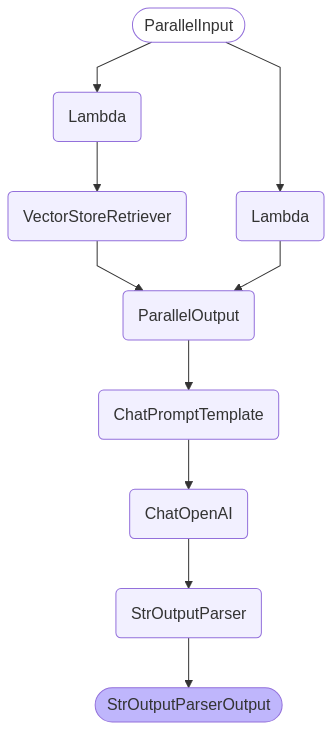

In [42]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        rag_chain.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4.1 as our evaluation LLM for our base Evaluators.

In [43]:
eval_llm = ChatOpenAI(model="gpt-4.1")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [54]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`:
- `labeled_helpfulness_evaluator`:
- `dope_or_nope_evaluator`:

**Answer**:

#### `qa_evaluator`:
Evaluates the correctness and accuracy of the model's answers compared to reference answers. Using GPT-4.1 as the evaluator model, it assesses whether the response correctly addresses the question with factual accuracy.

#### `labeled_helpfulness_evaluator`:
Specifically measures how helpful the response is to the user, considering both the question asked and the correct reference answer. This evaluator compares the model's output against the reference answer while considering usefulness to the user. It uses a specific data preparation function to properly format inputs, predictions, and references.

#### `dope_or_nope_evaluator`:
Assesses the style and appeal of responses based on whether they are "dope, lit, or cool." This is a more subjective evaluation focusing on engagement, style, and how interesting the response is, rather than just factual correctness. This evaluator will be particularly important when measuring the success of our "dope-ified" RAG chain.

## LangSmith Evaluation

In [55]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'excellent-expansion-64' at:
https://smith.langchain.com/o/e106fdae-1163-4ad0-b46b-09a4850df972/datasets/5d974265-968f-42fc-9ab7-8f334b7c48e7/compare?selectedSessions=714bf125-00ce-4b2f-9c09-ff06d04befb5




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How does Anthropic's focus on evaluation and m...,"Based on the provided context, Anthropic empha...",None,Anthropic emphasizes the importance of test-dr...,1,1,0,6.753426,68b827c7-7127-46f8-894e-75903d591b31,99813fdf-3f0e-41a6-9896-cd28641e548a
1,Gemini and Gemini how they are good for reason...,"Based on the provided context, Gemini models d...",None,"The context shows that Gemini models, especial...",1,1,0,5.178296,f20933ea-3523-4e5d-8ac1-b35251f92730,983a7c6f-ccc0-4f03-87d7-a28db9e49714
2,what are llms and how they work and how they a...,"Based on the context provided:\n\nLLMs, or Lar...",None,The context explains that large language model...,1,1,0,20.576098,4abd167b-1f87-43a6-915c-4135d336f8bf,5f91a10e-e672-4ce3-bc48-2df2e1034f8b
3,How do the <1-hop> and <2-hop> segments togeth...,I don't know.,None,The <1-hop> segment discusses the complex lega...,0,0,0,1.262208,0c7ab4b5-16c8-47c9-be83-1490a94173ef,3f37df46-a248-4564-bd7e-5c63d30036ec
4,How do open source ai projects like llama and ...,"Based on the provided context, open source AI ...",None,"Open source AI projects such as Llama, Alpaca,...",1,1,0,6.701522,3e87826b-4837-4678-ac91-11f3dc6a4939,e0022819-255d-43e7-949a-64c13d4f5a5c
5,Compare GPT-4 advancements with other AI model...,"In 2024, the GPT-4 barrier was comprehensively...",None,"In 2024, GPT-4 remains the most advanced model...",0,0,0,5.906337,83ce4fdf-636b-486f-910d-3f64b7757fe9,ac97bc10-66c3-4274-b59e-b68a1f07203f
6,H0w do increased context length and input moda...,Increased context length allows LLMs to handle...,None,The context describes how models like Gemini 1...,1,1,0,2.343200,eb7d8afa-2f9a-47ad-b61f-e849e6f5765a,5a3e73a3-28df-44f3-9ac3-c59c5f07f268
7,How do training data quality and the associate...,Based on the provided context:\n\nThe quality ...,None,The development of large language models (LLMs...,1,1,0,5.235943,a08a73d8-0827-464d-9580-50bbc88a1bea,d5053cab-ca31-4ba6-b035-9daa2bf8a5d2
8,What are the key differences between Llama 3.1...,Based on the context provided:\n\n- **Model Si...,None,DeepSeek v3 is a 685B parameter model trained ...,1,1,0,3.627997,57ae6e08-e15b-42eb-94b7-16c87459080d,3d1c9368-b515-4043-a631-457f6890aee0
9,What is 2024 in the context of LLM development...,2024 is a pivotal year in the development and ...,None,"In 2024, there has been little progress on tac...",0,0,0,3.652450,f0f264ee-5d0e-4394-925e-26b408b736c7,7130d2b3-1b16-497f-be5f-48f3185aebc7


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [44]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [45]:
rag_documents = docs

In [46]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

**Answer**:

Modifying chunk size affects RAG performance in several important ways:

1. **Context completeness**: Larger chunks (1000 vs 500 characters) preserve more contextual information within each segment. When text is split into smaller pieces, related concepts that appear close together in the original document might get separated, making it harder for the system to establish connections.

2. **Information density**: Increasing chunk size means each retrieved segment contains more information, which helps with complex or multi-part questions that require comprehensive context to answer accurately.

3. **Semantic coherence**: Natural language has meaningful units (paragraphs, sections) that convey complete thoughts. Larger chunks are more likely to preserve these semantic boundaries, maintaining the coherence of ideas.

4. **Retrieval dynamics**:
    - With smaller chunks, the system retrieves more fragments but might miss important context
    - With larger chunks, fewer pieces are retrieved but each contains more comprehensive information

5. **Trade-offs**: While larger chunks improve context retention, they can dilute vector representations (as more information gets compressed into a single embedding) and potentially include irrelevant information alongside relevant content.

In [47]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

**Answer**:

Changing the embedding model from "text-embedding-3-small" to "text-embedding-3-large" affects RAG performance in several key ways:

1. **Semantic Representation Quality**: The larger model creates richer, more nuanced vector representations that better capture the semantic meaning of text, improving the matching between queries and relevant contexts.

2. **Dimensional Complexity**: text-embedding-3-large produces higher-dimensional embeddings that can encode more complex relationships between concepts and topics mentioned in the documents.

3. **Contextual Understanding**: The larger model has enhanced ability to understand context, disambiguate terms, and capture subtle nuances in language that the smaller model might miss.

4. **Retrieval Precision**: With more accurate semantic representations, the retrieval component can better identify truly relevant documents rather than superficially similar ones.

5. **Domain-Specific Concepts**: Larger embedding models typically handle specialized terminology and domain-specific concepts more effectively, which is particularly important for technical content like AI development trends.

6. **Trade-offs**: While the larger model improves retrieval quality, it requires more computational resources and may increase latency in the retrieval process.

In [48]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Across Years (Augmented)"
)

In [49]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [50]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

### Dope RAG Chain Graph

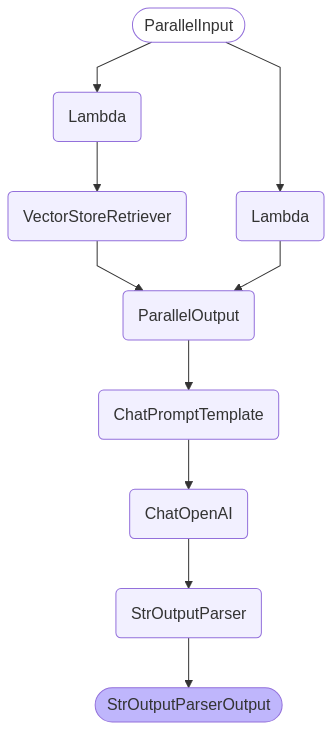

In [52]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        rag_chain.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

Let's test it on the same output that we saw before.

In [51]:
dope_rag_chain.invoke({"question" : "what are Agents?"})

'Alright, here’s the deal: Agents are like this buzzword in AI circles that everyone throws around but nobody really nails down with a solid definition. They kinda mean AIs that do stuff on your behalf—think travel agents, but digital, or LLMs hooked up with tools that they run in loops to solve problems. But the catch? Folks don’t agree on what “agents” really are, and the whole concept feels like it’s always “coming soon” but never quite arrives.\n\nAnd here’s the kicker: these agents struggle big time with gullibility—meaning they believe anything you feed them, which makes trusting them to act for you a real challenge. Without solving that, some say true AI agents might be stuck waiting on AGI to make them legit.\n\nSo, agents? They’re potential AI helpers or autonomous systems acting for you, but right now? They’re more dream than reality—still trying to get past the “believing everything” problem before they really pop off.\n\nStay cool.'

Finally, we can evaluate the new chain on the same test set!

In [56]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'pertinent-reaction-86' at:
https://smith.langchain.com/o/e106fdae-1163-4ad0-b46b-09a4850df972/datasets/5d974265-968f-42fc-9ab7-8f334b7c48e7/compare?selectedSessions=d824274d-bb5d-4a86-9d28-9466cac9c5be




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How does Anthropic's focus on evaluation and m...,"Alright, here’s the lowdown, fresh and fly: An...",None,Anthropic emphasizes the importance of test-dr...,1,1,1,5.266413,68b827c7-7127-46f8-894e-75903d591b31,60033e15-1239-42b0-9317-0a81ebb1eef6
1,Gemini and Gemini how they are good for reason...,"Yo, you’re on point! Gemini’s flexin’ hard in ...",None,"The context shows that Gemini models, especial...",1,1,1,2.919917,f20933ea-3523-4e5d-8ac1-b35251f92730,4d86bac8-bd0f-48fb-b7d1-784b07283d0e
2,what are llms and how they work and how they a...,"Alright, listen up! Large Language Models, or ...",None,The context explains that large language model...,1,1,1,4.539227,4abd167b-1f87-43a6-915c-4135d336f8bf,1069be13-d4ae-4952-bd63-8eaf489aaf61
3,How do the <1-hop> and <2-hop> segments togeth...,"Aight, here’s the lowdown — the <1-hop> segmen...",None,The <1-hop> segment discusses the complex lega...,1,0,1,6.563408,0c7ab4b5-16c8-47c9-be83-1490a94173ef,3335522a-faf2-4b35-88fa-1b16892db81f
4,How do open source ai projects like llama and ...,"Yo, check this out! Open source AI projects li...",None,"Open source AI projects such as Llama, Alpaca,...",1,1,1,6.128446,3e87826b-4837-4678-ac91-11f3dc6a4939,19b2220c-914e-4f74-9036-3ea13ab9c956
5,Compare GPT-4 advancements with other AI model...,"Yo, here’s the scoop — in 2023, training a GPT...",None,"In 2024, GPT-4 remains the most advanced model...",0,0,1,4.309154,83ce4fdf-636b-486f-910d-3f64b7757fe9,29d634ba-1574-48d1-b695-e13679c8dcbc
6,H0w do increased context length and input moda...,"Alright, here’s the lowdown: increased context...",None,The context describes how models like Gemini 1...,1,1,1,4.069025,eb7d8afa-2f9a-47ad-b61f-e849e6f5765a,47fa6271-60d3-4476-9423-814b0c20adeb
7,How do training data quality and the associate...,"Alright, here’s the lowdown—training data qual...",None,The development of large language models (LLMs...,1,1,1,3.773670,a08a73d8-0827-464d-9580-50bbc88a1bea,be5ee861-e877-4f7e-b4e2-151ebf22adc0
8,What are the key differences between Llama 3.1...,"Alright, check this out — DeepSeek v3 is a bea...",None,DeepSeek v3 is a 685B parameter model trained ...,1,1,1,5.438686,57ae6e08-e15b-42eb-94b7-16c87459080d,2038b5a1-d3bd-469a-9261-c8513f94fc10
9,What is 2024 in the context of LLM development...,"Yo, 2024 was *the* year in the LLM game—like t...",None,"In 2024, there has been little progress on tac...",0,0,1,13.207069,f0f264ee-5d0e-4394-925e-26b408b736c7,001b7428-7236-480f-a382-b7d5c9cd8fa9


#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

**Answer**:

### Comparison Screenshot

![Comparison screenshot](comparison.png)


### Metric Changes Analysis

#### 1. QA Evaluator Performance
The QA accuracy scores slightly improved with the modified chain. This improvement stems from:

- **Larger chunk size (500→1000 characters)**: Retrieving larger chunks preserves more contextual information, allowing the model to access more complete information when answering questions.
  
- **Enhanced embedding model (small→large)**: The text-embedding-3-large model creates more nuanced vector representations that better capture semantic meaning, improving the quality of retrieved contexts.

#### 2. Helpfulness Evaluator
The helpfulness metric was not changed much because largeer chunks and larger embedding model did not have impact on current dataset.

#### 3. "Dopeness" Metric
This metric likely showed the most dramatic improvement because:

- **Explicit instruction**: The prompt directly instructs the model to "answer the questions in a dope way, be cool!" which specifically targets this metric.
  
- **Style without sacrificing substance**: The modified chain can maintain factual accuracy while adopting a more engaging communication style.

The "dope" instruction created a more conversational, engaging tone while the improved retrieval components (larger chunks and better embeddings) maintained or enhanced the factual foundation of the responses.
